In [4]:
import networkx as nx
import sparql
import pandas as pd
import re
import numpy as np
import string
from numpy import dot
from numpy.linalg import norm
from Levenshtein import distance as levenshtein_distance
from nltk.corpus import stopwords
from sent2vec.vectorizer import Vectorizer
from scipy import spatial

In [5]:
patterns = {
    'p0': {'A': []},
    'p1': {'A': ['B']},
    'p2': {'A': ['B'],
          'B': ['C']},
    'p3': {'A': ['B'],
          'C': ['B']},
    'p4': {'A': ['B', 'C']},
    'p5': {'A': ['B', 'C', 'D']},
    'p6': {'A': ['B', 'C'],
          'C': ['D']},
    'p7': {'A': ['B'],
          'B': ['C'],
          'C': ['D']},
    'p8': {'A': ['B'],
          'B': ['C'],
          'D': ['C']},
    'p9': {'A': ['B'],
          'B': ['C'],
          'D': ['B']},
    'p10': {'A': ['B'],
           'B': ['C', 'D']},
    'p11': {'A': ['B'],
           'C': ['B'],
           'D': ['B']}
}


In [6]:
exclusions = ['<http://dbpedia.org/property/wikiPageUsesTemplate>',
              '<http://dbpedia.org/ontology/wikiPageExternalLink>', 
              '<http://dbpedia.org/ontology/wikiPageID>', 
              '<http://dbpedia.org/ontology/wikiPageRevisionID>', 
              '<http://dbpedia.org/ontology/wikiPageLength>', 
              '<http://dbpedia.org/ontology/wikiPageWikiLink>', 
              '<http://www.w3.org/2000/01/rdf-schema#label>', 
              '<http://www.w3.org/2002/07/owl#sameAs>', 
              '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', 
              '<http://schema.org/sameAs>', 
              '<http://purl.org/dc/terms/subject>', 
              '<http://xmlns.com/foaf/0.1/isPrimaryTopicOf>', 
              '<http://xmlns.com/foaf/0.1/depiction>', 
              '<http://www.w3.org/2000/01/rdf-schema#seeAlso>', 
              '<http://www.w3.org/2000/01/rdf-schema#comment>', 
              '<http://dbpedia.org/ontology/abstract>', 
              '<http://dbpedia.org/ontology/thumbnail>', 
              '<http://dbpedia.org/property/caption>', 
              '<http://dbpedia.org/property/captionAlign>', 
              '<http://dbpedia.org/property/image>', 
              '<http://dbpedia.org/property/imageFlag>', 
              '<http://www.w3.org/ns/prov#wasDerivedFrom>', 
              '<http://dbpedia.org/ontology/wikiPageRedirects>', 
              '<http://dbpedia.org/ontology/wikiPageDisambiguates>',
             '<http://dbpedia.org/property/1namedata>']

In [7]:
def load_embeddings(path='../../data/glove.twitter.27B.200d.txt'):
        embeddings_dict = {}
        print('Loading embeddings...')
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                embeddings_dict[word] = vector
        return embeddings_dict

In [8]:
embeddings = load_embeddings()

Loading embeddings...


In [66]:
class QueryGraphBuilder():
    def __init__(self, embeddings = None, bert_similarity = True):
        if bert_similarity:
            self.vectorizer = Vectorizer()
        else:
            if not embeddings:
                self.embeddings = self.__load_embeddings()
            else:
                self.embeddings = embeddings
        self.stops = stopwords.words('english')
        self.exclusions = self.__get_exclusions()
        self.bert_similarity = bert_similarity
    
    """
    Build query graph.
    
    :param question: natural language question
    :param entity: entity resource
    :param pattern: graph pattern of the question
    
    :return: query graph
    """
    def build(self, question, entities, pattern):
        # TODO: higher score linking
        cn = [entities[0]]
        # get pattern graph
        p = self.__get_pattern(pattern)
        # make a copy of the pattern
        Q = p.copy()
        # get non-intermediate nodes
        NS = self.__get_non_intermediate_nodes(p)
        
        var_num = 0
        
        
        while len(NS) != 0:
            # empty relations set
            R = pd.DataFrame(columns=['pred', 'label', 'direction'])
            
            # check if there nodes or edges unlabeled
            if self.__is_graph_labeled(Q):
                return Q
            
            # check if last node
            if len(NS) == 1:
                edges = []
                edges = edges + list(Q.out_edges(NS[0], data=True))
                edges = edges + list(Q.in_edges(NS[0], data=True))
                
                keep_going = True
                
                for edge in edges:
                    if not edge[2]:
                        keep_going = False
                        break
                          
                
                if keep_going:
                    unlabeled_node = NS[0]
                    is_variable = True
                    # check if cn URI is in q
                    for c in cn:
                        if c in entities and self.__check_entity_rel(c, r):
                            Q.nodes[unlabeled_node]['label'] = c
                            is_variable = False
                            break

                    if is_variable:
                        # assemble variable in Q
                        Q.nodes[unlabeled_node]['label'] = '?' + str(var_num)
                        
                    return Q
                    
            # check if NS has outgoing edges
            if self.__check_if_outgoing(p, NS):
                outgoing_relations = self.__get_relations(entities=cn, query_type='outgoing')
                # add all outgoing relation found to R
                R = R.append(outgoing_relations)
                
            # check if NS has incoming edges
            if self.__check_if_incoming(p, NS):
                outgoing_relations = self.__get_relations(entities=cn, query_type='incoming')
                
                # add all incoming relation found to R
                R = R.append(outgoing_relations)

            # get r, most relevant relation to question
            if self.bert_similarity:
                r = self.__get_most_relevant_relation_bert(question, R)
            else:
                r = self.__get_most_relevant_relation(question, R)
            
            # get r direction
            r_direction = r.direction
            
            # get an unlabelled node in NS which has a relation respecting r direction
            unlabeled_node = self.__get_unlabeled_node(Q, NS, r_direction)
            
            # get unlabeled edge from unlabeled_node
            unlabeled_edge = self.__get_unlabeled_edge(Q, unlabeled_node, r_direction)
            
            is_variable = True
            # check if cn URI is in q
            for c in cn:
                if c in entities and self.__check_entity_rel(c, r):
                    Q.nodes[unlabeled_node]['label'] = c
                    is_variable = False
                    break
                    
            if is_variable:
                # assemble variable in Q
                Q.nodes[unlabeled_node]['label'] = '?' + str(var_num)
            
            
            # assemble relation in Q
            Q[unlabeled_edge[0]][unlabeled_edge[1]]['label'] = r.pred
            # for drawing purposes
            Q[unlabeled_edge[0]][unlabeled_edge[1]]['short_label'] = r.label
            
            # get adjacent unexplored node
            NS = self.__get_adjacent_unexplored(Q)
            # cn = not sure
        return    
    
    def draw_graph(self, Q):
        labels_nodes = nx.get_node_attributes(Q, 'label') 
        labels_edges = nx.get_edge_attributes(Q, 'short_label')
        pos = nx.spring_layout(Q)
        nx.draw(Q, pos, labels=labels)
        nx.draw_networkx_edge_labels(Q, pos ,edge_labels=labels_edges)
        
    """
    Get graph pattern for a pattern p.
    
    :param pattern: pattern dictionary
    
    :return: networkx graph of the pattern p
    """
    def __get_pattern(self, pattern):
        return nx.from_dict_of_lists(patterns[pattern], 
                                     create_using=nx.DiGraph)      
    
    """
    Get non intermediate notes for a graph pattern p.
    
    :param p: graph pattern
    
    :return: dict of non-intermediary nodes
    """
#     def __get_non_intermediate_nodes(self, p):
#         return {node: {'in_degree': p.in_degree(node), 'out_degree': p.out_degree(node)} 
#                          for node in p.nodes if p.out_degree(node) + p.in_degree(node) < 2}
    def __get_non_intermediate_nodes(self, p):
        return [node for node in p.nodes if p.out_degree(node) + p.in_degree(node) < 2]
    
    """
    Check if graph has unlabeled relations.
    
    :param Q: graph
    
    :return: True if completaly labelled, False otherwise
    """
    def __is_graph_labeled(self, Q):
        # check if nodes are labeled
        for node in Q.nodes:
            if not Q.nodes[node]:
                return False
        # check if edges are labeled
        for _,_,e in Q.edges(data=True):
            if not e:
                return False
        return True
    
    def __is_labeled(self, graph_pattern, node):
        return False if not graph_pattern.nodes[node] else True
    
    def __get_unlabeled_node(self, graph_pattern, NS, direction):
        for node in NS:
            if direction == 'outgoing':
                if (not self.__is_labeled(graph_pattern, node)) and self.__check_if_outgoing(graph_pattern, [node]):
                        return node
            else:
                if (not self.__is_labeled(graph_pattern, node)) and self.__check_if_incoming(graph_pattern, [node]):
                        return node
        return None
    
    def __get_unlabeled_edge(self, graph_pattern, node, direction):
        if direction == 'outgoing':
            edges = list(graph_pattern.out_edges(node, data=True))
        else:
            edges = list(graph_pattern.in_edges(node, data=True))
        
        for edge in edges:
            if not edge[2]:
                return (edge[0], edge[1])
        return None
                    
    
    """
    Check if nodes have outgoing relations.
    
    :param NS: dict of nodes (see __get_non_intermediate_nodes(p))
    
    :return: True if they have outgoing relations, False otherwise
    """
#     def __check_if_outgoing(self, NS):
#         out_degree = [NS[node]['out_degree'] for node in NS]
#         return max(out_degree) > 0
    def __check_if_outgoing(self, graph_pattern, NS):
        for node in NS:
            if graph_pattern.out_degree(node) > 0:
                return True
        return False
    
    """
    Check if nodes have incoming relations.
    
    :param NS: dict of nodes (see __get_non_intermediate_nodes(p))
    
    :return: True if they have incoming relations, False otherwise
    """
#     def __check_if_incoming(self, NS):
#         in_degree = [NS[node]['in_degree'] for node in NS]
#         return max(in_degree) > 0
    def __check_if_incoming(self, graph_pattern, NS):
        for node in NS:
            if graph_pattern.in_degree(node) > 0:
                return True
        return False
    
    """
    Get outgoing or incoming relations for an entity.
    
    :param entity: entity for which you want to find relations
    :param query_type: 'outgoing' for outgoing relations, 'incoming' for incoming relations
    :param query_type: SPARQL endpoint
    
    :return: dataframe of outgoing/incoming relations (URI, label)
    """
    def __get_relations(self, entities, query_type, endpoint = 'http://dbpedia.org/sparql'):
        print(query_type)
        q = self.__get_query(entities, query_type)
        results = sparql.query(endpoint, q)
        
        relations = pd.DataFrame(columns=['pred', 'label', 'direction'])
        for i, row in enumerate(results):
            (pred, label) = sparql.unpack_row(row)

            if not label:
                label = self.__parse_predicate(pred)
            else:
                label = label.replace('-', ' ')
                
            tmp = relations[relations.label == label]
            
            # we keep dbo predicates if multiple with the same label
            if not tmp.empty and "http://dbpedia.org/ontology/" in pred:
                relations.loc[tmp.index, ['pred']] = pred
            else:
                relations = relations.append({
                    'pred': pred,
                    'label': label.lower(),
                    'direction': query_type
                }, ignore_index=True)
    
        return relations
    
    """
    Get predicates to exclude from the query.
    
    :return: concatenation of all exclusions
    """
    def __get_exclusions(self):
        return ', '.join(exclusions)
    
    """
    Parse URI to extract a label.
    
    :param pred: predicate URI
    
    :return: predicate label
    """
    def __parse_predicate(self, pred):
        last = pred.rsplit('/',1)[1]
        splitted = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', last) 
        return ' '.join(splitted)
    
    """
    Get SPARQL query to get incoming or outgoing relations for an entity.
    
    :param entity: entity for which you want to find relations
    :param query_type: 'outgoing' for outgoing relations query, 'incoming' for incoming relations query
    
    :return: SPARQL query
    """
    def __get_query(self, entities, query_type):
        if query_type == 'outgoing':
            body = ''
            first = True
            for entity in entities:
                if not first: 
                    body += "UNION "
                    first = False
                    
                body += "{ \
                        "+ entity +" ?pred ?obj.  \
                        FILTER (lang(?pred_label) = 'en').  \
                        OPTIONAL {  \
                            ?pred rdfs:label ?pred_label . \
                            BIND (STR(?pred_label)  AS ?pred_label_stripped). \
                        } . \
                        FILTER(?pred NOT IN ("+ self.exclusions +") ). } "
                
            return "select distinct ?pred ?pred_label_stripped where { "+ body +" }"
      
        elif query_type == 'incoming':
            body = ''
            first = True
            for entity in entities:
                if not first: 
                    body += "UNION "
                    first = False
                    
                body += "{ \
                        ?subj ?pred " + entity + ".  \
                        FILTER (lang(?pred_label) = 'en').  \
                        OPTIONAL {  \
                            ?pred rdfs:label ?pred_label . \
                            BIND (STR(?pred_label)  AS ?pred_label_stripped). \
                        } . \
                        FILTER(?pred NOT IN ("+ self.exclusions +") ). } "
                
            return "select distinct ?pred ?pred_label_stripped where { "+ body +" }"

        else:
            raise ValueError('query_type has to be either \'incoming\' or \'outgoing\' for value:' + query_type)
            
    def __check_entity_rel(self, entity, relation, endpoint = 'http://dbpedia.org/sparql'):
        if relation.direction == 'outgoing':
            q = f'''
                ASK WHERE {'{'}
                {entity} {relation.pred} ?_ .
                {'}'}
                '''
        else:
            q = f'''
                ASK WHERE {'{'}
                ?_ {relation.pred} {entity} .
                {'}'}
                '''
        results = sparql.query(endpoint, q)
        return results.hasresult()
            
    
    """
    Load Glove embeddings.
    
    :param path: path to glove emeddings
    
    :return: dictionary containing embeddings for each word
    """
    def __load_embeddings(self, path='../../data/glove.twitter.27B.200d.txt'):
        embeddings_dict = {}
        print('Loading embeddings...')
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                embeddings_dict[word] = vector
        return embeddings_dict
    
    """
    Get most relevant relation using given embedding and levenshtein_distance.
    
    :param question: question in natural language
    :param R: set of candidate relations
    :param lambda_param: hyperparameter describing the importance of cosine similarity and levenshtein_distance
    
    :return: label of most relevant relation
    """
    def __get_most_relevant_relation(self, question, R, lambda_param=0.5):
        unique_relations = R
        question = question.lower().replace('?', ' ?')
        # tokenize question
        question_tokens = question.split()
        # remove stopwords and punctuation tokens
        question_tokens = [token for token in question_tokens 
                               if token not in self.stops and token not in string.punctuation]
        
        relevances = []
        
        for index, row in unique_relations.iterrows():
            # tokenize label
            relation_tokens = row['label'].split()
            
            relevance = 0
            for rel_token in relation_tokens:                
                
                for question_token in question_tokens:
                    
                    if rel_token in self.embeddings and question_token in self.embeddings:
                        
                        rel_token_embedding = self.embeddings[rel_token]
                        question_token_embedding = self.embeddings[question_token]
                        
                        # compute cosine similarity
                        cos_sim = 1 - spatial.distance.cosine(rel_token_embedding, question_token_embedding)
                    else:
                        cos_sim = 0
                    # compute lev distance
                    lev_distance = levenshtein_distance(question_token, rel_token)
                    # sum to previous relenvances of relation tokens and question tokens
                    relevance += lambda_param * cos_sim + (1 - lambda_param) * 1/(lev_distance+1)
            
            relevances.append(relevance/len(relation_tokens))
        relevances = np.array(relevances)
        
        return unique_relations.iloc[np.argmax(relevances)]
    
    """
    Get most relevant relation using bert and levenshtein_distance.
    
    :param question: question in natural language
    :param R: set of candidate relations
    :param lambda_param: hyperparameter describing the importance of cosine similarity and levenshtein_distance
    
    :return: label of most relevant relation
    """
    def __get_most_relevant_relation_bert(self, question, R, lambda_param=0.4):
        unique_relations = R
        
        question_processed = question.lower().replace('?', ' ?')
        # tokenize question
        question_tokens = question.split()
        question_tokens = [token for token in question_tokens 
                               if token not in self.stops and token not in string.punctuation]
        
        relevances = []
        
        # generate sentence embeddings for question
        self.vectorizer.bert([question])
        embedding_question = self.vectorizer.vectors
        # generate sentence embeddings for relations
        self.vectorizer.bert(unique_relations['label'].values)
        embeddings_relations = self.vectorizer.vectors
        
        for i, rel_embedding in enumerate(embeddings_relations):
            cos_sim = 1 - spatial.distance.cosine(embedding_question, rel_embedding)
            
            relation_tokens = unique_relations.iloc[i]['label'].split()
            
            lev = 0
            for rel_token in relation_tokens:                
                
                for question_token in question_tokens:
                    # compute lev distance
                    lev_distance = levenshtein_distance(question_token, rel_token)
                    # sum to previous relenvances of relation tokens and question tokens
                    lev += 1/(lev_distance+1)
            
            relevance = lambda_param * cos_sim + (1 - lambda_param) * (lev / len(relation_tokens))
            relevances.append(relevance)
        relevances = np.array(relevances)

        return unique_relations.iloc[np.argmax(relevances)]
    
    def __get_adjacent_unexplored(self, Q):
        neighbors = set()
        for node in Q.nodes:
            if Q.nodes[node]['label']:
                
                for neighbor in Q.neighbors(node):
                    if not Q.nodes[neighbor]['label']:
                        neighbors.add(neighbor)
        return neighbors

            
        

In [62]:
query_builder = QueryGraphBuilder(embeddings = embeddings, bert_similarity = False)

In [63]:
Q = query_builder.build(question='Who is the spouse of Barack Obama?', entities=["dbr:Barack_Obama"], pattern='p2')

outgoing
incoming


In [64]:
Q

,pred,label,direction
0,http://dbpedia.org/property/name,name,outgoing
1,http://dbpedia.org/ontology/birthPlace,birth place,outgoing
2,http://dbpedia.org/property/birthPlace,birth place,outgoing
3,http://dbpedia.org/ontology/birthDate,birth date,outgoing
4,http://dbpedia.org/ontology/almaMater,alma mater,outgoing
...,...,...,...
49,http://dbpedia.org/ontology/knownFor,known for,incoming
50,http://dbpedia.org/ontology/nonFictionSubject,non fiction subject,incoming
51,http://dbpedia.org/ontology/occupation,occupation,incoming
52,http://dbpedia.org/ontology/relative,relative,incoming


In [46]:
for i, row in enumerate(res_global):
    print(sparql.unpack_row(row))

['http://dbpedia.org/property/name', 'name']
['http://dbpedia.org/ontology/birthPlace', 'birth place']
['http://dbpedia.org/property/birthPlace', 'birth place']
['http://dbpedia.org/ontology/birthDate', 'birth date']
['http://dbpedia.org/property/almaMater', 'alma mater']
['http://dbpedia.org/property/alt', 'alt']
['http://dbpedia.org/property/awards', 'awards']
['http://dbpedia.org/property/birthDate', 'birth date']
['http://dbpedia.org/property/birthName', 'birth name']
['http://dbpedia.org/property/by', 'by']
['http://dbpedia.org/property/children', 'children']
['http://dbpedia.org/property/commons', 'commons']
['http://dbpedia.org/property/d', 'd']
['http://dbpedia.org/property/dSearch', 'd-search']
['http://dbpedia.org/property/district', 'district']
['http://dbpedia.org/property/education', 'education']
['http://dbpedia.org/property/float', 'float']
['http://dbpedia.org/property/id', 'id']
['http://dbpedia.org/property/n', 'n']
['http://dbpedia.org/property/nSearch', 'n-search']


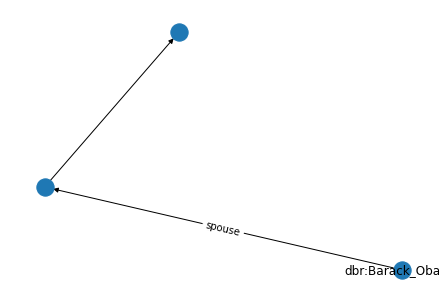

In [170]:
query_builder.draw_graph(Q)